In [29]:
import setpath
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from datasketch import MinHashLSH, MinHash
import numpy as np
from torch.utils.data import DataLoader
from run.resnet import TesNet
import torch
import torchvision.transforms as transforms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [ ]:
from prepare.eegdataset import GeneralEEGImageDataset, MySubset


data_path = '/data0/tianjunchao/dataset/CVPR2021-02785/data/img_pkl/32x32'
# dataset = GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=8)
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation((30)),
    # transforms.RandomCrop(224),
    # transforms.ToTensor(),
    # one channel
    # transforms.Resize((256, 256)),
    # transforms.RandomRotation(20),
    # transforms.RandomCrop(224),
    transforms.Normalize([0.512, 0.512, 0.512], [0.228, 0.228, 0.228]),
])
n_samples = 1
# dataset = C_GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=8, n_samples=n_samples)
dataset = GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=8)
# dataset = GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=4, n_samples=n_samples)
scale = 2
dataset = MySubset(dataset, range(len(dataset)), transform=None)
# dataset = MySubset(dataset, range(len(dataset)), train_transforms)
dataloader = DataLoader(dataset, batch_size=128)

In [ ]:

# 使用预训练的ResNet18提取特征



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fea_e = TesNet(pretrained=True).fea_e.to(device)
fea_e.eval()

# 提取图像特征
features = []
labels = []
total = 0
with torch.no_grad():
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        emb = fea_e(inputs)
        features.append(emb.view(inputs.size(0), -1).cpu().numpy())
        labels.extend(targets.tolist())
        print('total: ', total)
        total += inputs.size(0)
        if total >= 2e3:
            break

features = np.vstack(features)

In [31]:
features.shape

(2048, 512)

/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from

KeyboardInterrupt: 

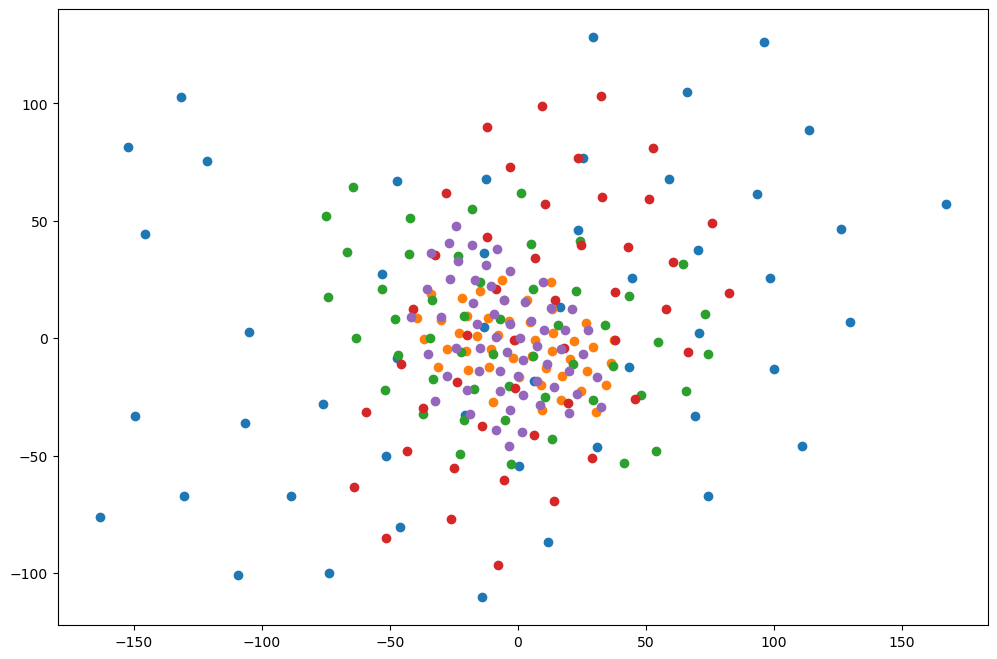

In [32]:

# 按类别进行聚类和可视化
n_clusters = 1  # 聚类数
tsne = TSNE(n_components=2, random_state=42)

plt.figure(figsize=(12, 8))
for label in set(labels):
    class_members = (np.array(labels) == label)
    class_features = features[class_members]
    class_tsne = tsne.fit_transform(class_features)
    kmeans = KMeans(n_clusters=1, random_state=42)
    cluster_labels = kmeans.fit_predict(class_tsne)

    for i in range(n_clusters):
        cluster_members = (cluster_labels == i)
        plt.scatter(class_tsne[cluster_members, 0], class_tsne[cluster_members, 1], label=f'Class {label} - Cluster {i}')

plt.legend()
plt.title(f"t-SNE Visualization with K-means Clustering for Class {label}")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [ ]:
# 使用局部敏感哈希（LSH）找到相似的图像
threshold = 0.01  # 相似度阈值
lsh = MinHashLSH(threshold=threshold, num_perm=128)
minhashes = {}

for i, feature in enumerate(features):
    m = MinHash(num_perm=128)
    for value in feature:
        m.update(str(value).encode('utf8'))
    lsh.insert(i, m)
    minhashes[i] = m

In [ ]:
# 检查哈希桶中的图像对
duplicates = set()
for i in range(len(features)):
    result = lsh.query(minhashes[i])
    if len(result) > 1:
        for j in result:
            if j != i and dataset[i][1] != dataset[j][1]:
                duplicates.add(tuple(sorted((i, j))))

print("找到的不同类别的相似图像对：", duplicates)

In [25]:
print(len(minhashes))

2048
